In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.stats import mode
import matplotlib.pyplot as plt

### Dataset 6 clusters - 4 globulares 2 segmentados lua

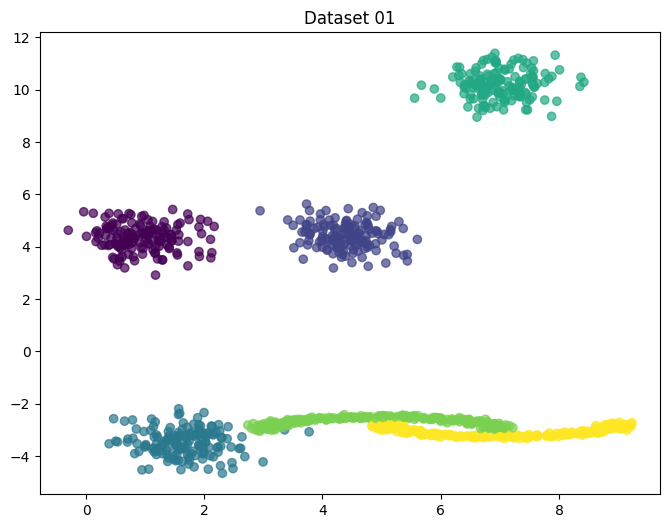

In [2]:
# Definir uma semente aleatória para reprodutibilidade
np.random.seed(42)

# Gerar dados globulares
globular1, labels1 = make_blobs(n_samples=150, centers=1, cluster_std=0.50, random_state=0)
globular2, labels2 = make_blobs(n_samples=150, centers=1, cluster_std=0.50, random_state=1)
globular3, labels3 = make_blobs(n_samples=150, centers=1, cluster_std=0.50, random_state=2)
globular4, labels4 = make_blobs(n_samples=150, centers=1, cluster_std=0.50, random_state=3)

# Gerar dados aninhados (em forma de luas)
nested, labels5 = make_moons(n_samples=500, noise=0.07)
labels5 += 4  # Ajustar os rótulos para que sejam distintos dos globulares

# Combinando todos os dados e rótulos
combined_dataset = np.vstack([globular1, globular2 + [6, 0], globular3 + [3, 6], globular4 + [6, 6], nested * np.array([2, 0.5]) + [5, -3]])
combined_labels = np.concatenate([labels1, labels2 + 1, labels3 + 2, labels4 + 3, labels5])

# Plotando o dataset combinado
plt.figure(figsize=(8, 6))
plt.scatter(combined_dataset[:, 0], combined_dataset[:, 1], c=combined_labels, cmap='viridis', alpha=0.7)
plt.title("Dataset 01")
plt.show()


In [3]:
print(np.unique(combined_labels))

[0 1 2 3 4 5]


###Ensemble

In [4]:
def generate_base_partitions(X, n_clusters_list, algorithms):
    """ Gera múltiplas partições base com diferentes algoritmos. """
    base_partitions = []
    for algo in algorithms:
        for k in n_clusters_list:
         #   for _ in range(n_init):
                if algo == "kmeans":
                    model = KMeans(n_clusters=k, n_init='auto', random_state=None)
                elif algo == "agglomerative":
                    model = AgglomerativeClustering(n_clusters=k)
                elif algo == "spectral":
                    model = SpectralClustering(n_clusters=k, random_state=None)
                labels = model.fit_predict(X)
                base_partitions.append(labels)
    return base_partitions

def create_coassociation_matrix(base_partitions, n_samples):
    """ Cria a matriz de co-associação a partir das partições base. """
    coassociation_matrix = np.zeros((n_samples, n_samples))
    n_partitions = len(base_partitions)

    for labels in base_partitions:
        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels[i] == labels[j]:
                    coassociation_matrix[i, j] += 1
                    if i != j:
                        coassociation_matrix[j, i] += 1

    # Normalizando a matriz de co-associação
    coassociation_matrix /= n_partitions
    return coassociation_matrix

def consensus_clustering(coassociation_matrix, n_clusters):
    """ Aplica clustering baseado em ligação na matriz de co-associação. """
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    consensus_labels = model.fit_predict(1 - coassociation_matrix)
    return consensus_labels

def evaluate_ensemble(X, true_labels, n_clusters_list, algorithms, n_clusters):
    """ Avalia o clustering ensemble usando ARI e Silhueta. """
    base_partitions = generate_base_partitions(X, n_clusters_list, algorithms)
    coassociation_matrix = create_coassociation_matrix(base_partitions, X.shape[0])
    consensus_labels = consensus_clustering(coassociation_matrix, n_clusters)
    ari_score = adjusted_rand_score(true_labels, consensus_labels)
    silhouette_avg = silhouette_score(X, consensus_labels)
    return ari_score, silhouette_avg



### Experimentos Ensemble

In [13]:
# Definindo os parâmetros para o ensemble
n_clusters_list = [4,6,8,10,12,14]  # Difente número de partições
algorithms = ['kmeans', 'agglomerative', 'spectral']  # Algoritmos
n_clusters = 14  # Número de clusters da partição final

# Avaliando o ensemble de clustering
ari_score, silhouette_avg = evaluate_ensemble(combined_dataset, combined_labels, n_clusters_list, algorithms, n_clusters)

# Exibindo os resultados
print("Adjusted Rand Index:", ari_score)
print("Silhouette Score:", silhouette_avg)

Adjusted Rand Index: 0.5383990082728851
Silhouette Score: 0.32844105494987796


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### Experimento Clustering Individuais

In [6]:
def analyze_clustering(X, true_labels, n_clusters):
    """ Aplica diferentes algoritmos de clustering e calcula ARI e Silhuete. """
    algorithms = {
        'KMeans': KMeans(n_clusters=n_clusters, n_init='auto', random_state=None),
        'Spectral': SpectralClustering(n_clusters=n_clusters, random_state=None),
        'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters)
    }
    results = {}
    for name, algo in algorithms.items():
        labels = algo.fit_predict(X)
        ari = adjusted_rand_score(true_labels, labels)
        silhouette = silhouette_score(X, labels)
        results[name] = (ari, silhouette)
    return results

In [12]:
# Avaliando os algoritmos de clustering individualmente
results = analyze_clustering(combined_dataset, combined_labels, n_clusters=14)

# Exibindo os resultados
for method, scores in results.items():
    print(f"{method} - Adjusted Rand Index: {scores[0]:.5f}, Silhouette Score: {scores[0]:.5f}")


KMeans - Adjusted Rand Index: 0.49735, Silhouette Score: 0.49735
Spectral - Adjusted Rand Index: 0.42775, Silhouette Score: 0.42775
Agglomerative - Adjusted Rand Index: 0.43818, Silhouette Score: 0.43818
